In [1]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt

class SAR_ADC:
    """SAR ADC class with mismatch"""
    
    def __init__(self, v_fs=8, n=3, v_cm=4, mismatchStd=0.0,  radix=2, flag='good', seed=1):
        """initial values"""
        self.v_fs = v_fs #full scale volt of SAR ADC
        self.n = n #number of bits
        self.v_cm = v_cm
        self.amp = np.max([v_fs - v_cm, v_cm-0]) 
        self.v_ref = v_fs #reference volt
        self.mismatchStd = mismatchStd #mismatch stand
        self.radix = radix #radix of capacitance array
        self.flag = flag #mismatch flag('good' or 'bad')
        self.seed = seed #random seed, used to fix the random values.
        self.sar_logic = {-1:1, 1:0} #SAR logic
        self.capArray = self.synthesizeCapArray() #according to mismatchStd and random seed to generate a capacitance array
        
    def DAC(self, N):
        """function to caculate dac-output by given v_ref, N(a string of N-bit digital input like '1011')"""
        weights = self.capArray[:-1]/np.sum(self.capArray) #caculate the weights by given capacitance array
        v_dac = np.dot(np.array(list(N),dtype=np.float)*self.v_ref, weights) #caculate the dac output
        return v_dac

    def synthesizeCapArray(self):
        """function to generate a capacitance array according to given mismatchStd and random seed"""
        capExp = [i for i in range(0, self.n)] 
        capExp.reverse()
        capExp.append(0)
        capExp = np.array(capExp)
        nomCap = self.radix**capExp
        np.random.seed(self.seed) #fix the random seed
        if self.flag == 'bad':
            capArray = np.random.normal(nomCap, self.mismatchStd*nomCap) 
        elif self.flag == 'good':
            capArray = np.random.normal(nomCap, self.mismatchStd*np.sqrt(nomCap))
        else:
            print("Warning: flag must be set.")
        return capArray

    def complier_and_SAR_logic(self, v_in, v_dac):
        """comlier and SAR logic parts"""
        b = self.sar_logic.get(np.sign(v_dac- v_in), 1) 
        return str(b)

    def register(self, b, clock, N):
        """register update model, b is the value of current bit that need to update. 
        clock is the the current clock value, N is the current digital code. 
        The output is the new digital value after update."""
        N_new_l = list(N) #transform the code string into list in order to update the bit value
        N_new_l[clock] = b #change the bit value
        if clock < (len(N)-1): #if it's not the last clock in a period, change next bit into 1.
            N_new_l[clock+1] = '1'
        N_new = ''.join(N_new_l) #transform into string
        return N_new

    def main(self, v_in):
        """SAR_ADC main function, caculate a list of digital output in a period"""
        N='1'+(self.n-1)*'0' #Set the first digital output code
        outputs = [N] 
        for i in range(self.n):
            v_dac = self.DAC(N) #caculate the current analog volt 
            b = self.complier_and_SAR_logic(v_in, v_dac) #determine the value of current bit(0 or 1)
            N = self.register(b, i, N) #update the digital code 
            outputs += [N] #add the current digital code into outputs list
        del outputs[-2]
        return outputs

"""Test part"""
sar = SAR_ADC(v_fs=8, n=3, v_cm=4)
sar.main(4)

['100', '110', '100']

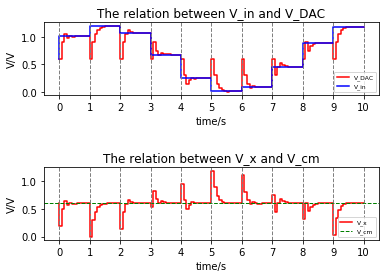

In [46]:
"""Debug model"""

SAR_ADC_model = SAR_ADC(v_fs=1.2, n=12, v_cm=0.6, mismatchStd=0, radix=2, flag='good', seed=31)


def plot(sar_adc, periods):
    """function to plot the """
    x= np.arange(0, periods*n+1, n) #the x axis point of v_in
    x1 = np.arange(0, periods*n+1, 1) #the x axis potin of v_dac, v_x
    v_in = sar_adc.amp*np.sin(2*np.pi*0.01*x) + sar_adc.amp  #define the input signal V_in
    v_x = [v_cm] #first value of V_x
    v_dac = [sar_adc.v_ref/2] #first value of V_dac
    
    #caculate V_dac and V_x value in every periods
    for v_in_i in v_in[1:]:
        v_dac_i = [sar_adc.DAC(N) for N in sar_adc.main(v_in_i)] #caculate the V_dac in every clock in 1 periods
        v_x_i = list(map(lambda i: i-v_in_i+v_cm, v_dac_i))  #caculate the V_x in every clock in 1 periods
        v_dac += v_dac_i #add the i-th v_dac into list v_dac
        v_x += v_x_i #add the i-th v_dac into list v_dac

    
    #plot
    plt.figure()
    #plot first sub figure for V_dac and V_in
    sub1 = plt.subplot(2,1,1)
    plt.title('The relation between V_in and V_DAC')
    sub1.step(x1, v_dac,  color='red', label='V_DAC') #plot the curve of V_DAC-V_cm
    sub1.step(x, v_in,  color='blue', label='V_in') #lot the curve of V_in
    plt.ylabel('V/V')
    plt.xlabel('time/s')
    plt.xticks([0]+[i for i in range(n, periods*n+1, n)], [0]+[i for i in range(1,periods+1)])
    #plt.xticks([0]+[i-n/2 for i in range(n, periods*n+1, n)], [0]+[i for i in range(1,periods+1)]) #mapping the original x axis value to period
    for i in range(0, periods*n+1, n): #plot the gridding
        plt.axvline([i],hold=None,linewidth=1,color='grey',linestyle="--")
    plt.legend(loc='lower right', prop={'size': 6})

    #plot the second subfigure for V_x
    sub2 = plt.subplot(2,1,2)
    plt.title('The relation between V_x and V_cm')
    sub2.step(x1, v_x,  color='red', label='V_x')
    plt.axhline([v_cm],hold=None,linewidth=1,color='green',linestyle="--",label='V_cm')
    plt.xticks([0]+[i for i in range(n, periods*n+1, n)], [0]+[i for i in range(1,periods+1)])
    #plt.xticks([0]+[i-n/2 for i in range(n, periods*n+1, n)], [0]+[i for i in range(1,periods+1)]) #to show periods
    for i in range(0, periods*n+1, n):
        plt.axvline([i],hold=None,linewidth=1,color='grey',linestyle="--")
    plt.legend(loc='lower right', prop={'size': 6})
    plt.xlabel('time/s')
    plt.ylabel('V/V')
    plt.subplots_adjust(hspace = 1)
    plt.show()

plot(sar_adc = SAR_ADC_model, periods= 10)

/Users/cpius/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


62.91629990832095
62.900086380223115
10.157691909165358
10.154998900478875


/Users/cpius/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


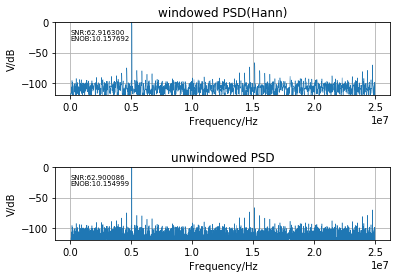

In [50]:
import numpy as np
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
import scipy.signal as signal

"""plot fft part"""

prime_number = 413
fs = 50e6
fft_size = 4096
v_fs = 1.2
n = 12
v_cm = 0.6
mismatchStd = 0.001
radix = 2
flag = 'bad'
seed = 1
sar_adc = SAR_ADC(v_fs, n, v_cm, mismatchStd, radix, flag, seed)
sar_adc_ideal = SAR_ADC(v_fs=v_fs, n=n, v_cm=v_cm, mismatchStd=0, radix=2, flag=flag, seed=seed)

def getSNR(fft_output, window):
    """function to caculate SNR"""
    max_index = prime_number #the index of max value
    if window == 'hann':
        a_signal = np.array([fft_output[max_index-1:max_index+2]]) #the 
        a_noise = np.append(fft_output[3:(max_index-1)], fft_output[(max_index+2):])
    else:
        a_signal = np.array([fft_output[max_index]])
        a_noise = np.append(fft_output[3:(max_index)], fft_output[(max_index+1):])
    p_signal = np.linalg.norm(a_signal) #abs(np.power(a_signal, 2))
    p_noise = np.linalg.norm(a_noise) #abs(np.power(a_noise, 2))
    SNR = 20*np.log10(p_signal/p_noise)
    return SNR

def getENOB(SNR):
    """function to caculate ENOB"""
    ENOB = (SNR-1.7609)/6.0206
    return ENOB


def plot_fft(prime_number, fs, fft_size, sar_adc):
    """function to plot the fft"""
    f_in = fs/fft_size*prime_number #define the input frequency
    x = np.linspace(0, 1, fs+1) 
    x = x[:fft_size]
    y_in = sar_adc.amp*np.sin(2*np.pi*f_in*x) + sar_adc.amp #define the input signal
    y_adc_output = [sar_adc.main(y_in_i)[-1] for y_in_i in y_in[:fft_size]] #caculate the SAR ADC output 
    y_dac_output = [sar_adc_ideal.DAC(y_i) for y_i in y_adc_output] #caculate the analog signal from ADC output 
    y_dac_win = y_dac_output*signal.hann(fft_size+1)[:-1]     #add a hann window function
    y_dac_unwin  = y_dac_output 
    
    x_f = np.array(range(0,int(fft_size/2+1)))/fft_size*fs #caculate the frequency value of x axis
    
    y_f_w = np.fft.rfft(y_dac_win, 4096) #caculate the fft given windowed analog output 
    y_fn_w = y_f_w/((fft_size/2)*((v_fs-v_cm)/2)) #normalization 
    y_p_w = 20*np.log10(y_fn_w)  #caculate the power 
    SNR_w = getSNR(y_f_w, 'hann') #caculate the SNR of windowed analog output 
    
    y_f_unw = np.fft.rfft(y_dac_unwin, 4096)  
    y_fn_unw = y_f_unw/((fft_size/2)*((v_fs-v_cm)/1)) #normalization
    y_p_unw = 20*np.log10(y_fn_unw) 
    SNR_unw = getSNR(y_f_unw, None)
    
    print(SNR_w)
    print(SNR_unw)
    print(getENOB(SNR_w))
    print(getENOB(SNR_unw))
    
    #plot part 
    plt.subplot(211)
    plt.title('windowed PSD(Hann)')
    plt.plot(x_f[2:], y_p_w[2:],linewidth=0.5)
    plt.ylim((-120, 0))
    plt.text(0, -20,'SNR:%f'%SNR_w,fontsize='x-small')
    plt.text(0,-30,'ENOB:%f'%getENOB(SNR_w),fontsize='x-small')
    plt.grid()
    plt.xlabel('Frequency/Hz')
    plt.ylabel('V/dB')
    
    plt.subplot(212)
    plt.title('unwindowed PSD')
    plt.text(0,-20,'SNR:%f'%SNR_unw,fontsize='x-small')
    plt.text(0,-30,'ENOB:%f'%getENOB(SNR_unw),fontsize='x-small')
    plt.plot(x_f[2:], y_p_unw[2:],linewidth=0.5)
    plt.ylim((-120, 0))
    plt.xlabel('Frequency/Hz')
    plt.ylabel('V/dB')
    plt.grid()
    plt.subplots_adjust(hspace = 1)
    plt.show()
    
plot_fft(prime_number, fs, fft_size, sar_adc)

/Users/cpius/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


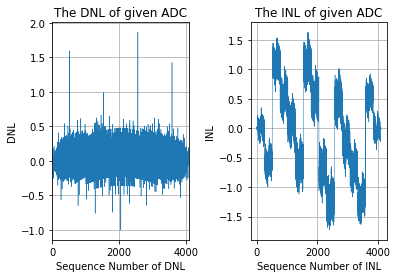

In [53]:
import numpy as np
import nltk
import matplotlib
import matplotlib.pyplot as plt

"""Code Destiny method part"""
N = 100000
fs = 45e6
f_in = 5.6018e6

v_fs = 1.2
n = 12
v_cm = 0.6
sigma = 0.005
radix = 2
flag = 'bad'
seed = 31

sar_adc = SAR_ADC(v_fs, n, v_cm, sigma, radix, flag, seed)

def getDNLs_INLs(N, fs, f_in, sar_dac):
    x = np.linspace(0, 1, fs+1)[:N]
    y_in = (v_fs/2)*np.sin(2*np.pi*f_in*x)+v_cm

    y_code_output = [sar_adc.main(y_in_i)[-1] for y_in_i in y_in]
    freqDist = nltk.FreqDist(y_code_output)

    dic = {}
    for key in freqDist:
        nCode = np.dot(np.array(list(key),dtype=np.float)*(2**len(key)), np.array([(1/2)**(i+1) for i in range(len(key))]))
        dic[nCode] = freqDist[key]

    code_bins = np.array([dic.get(i,0) for i in range(0, 2**n)])

    N_record_n = np.sum(code_bins[:2**(n-1)])
    N_record_p = np.sum(code_bins[2**(n-1):])

    v_offset = 0.5*sar_adc.amp*np.pi*np.sin((N_record_p-N_record_n)/(N_record_p+N_record_n))
    v_js = [-sar_adc.amp*np.cos(np.pi* ( np.sum(code_bins[:j])/ N) ) for j in range(0, 2**(n))]

    DNLs = [0.0]+ [(v_js[j+1] - v_js[j])*((2**(n))/v_fs)-1 for j in range(0, 2**(n)-1)]
    INLs = [np.sum(DNLs[:j+1]) for j in range(0, 2**(n))]
    return DNLs, INLs
    
def plot_DNL_INL(dnls, inls):
    x = np.linspace(0, len(dnls), len(dnls)+1)
    
    plt.figure()
    sub_dnls = plt.subplot(1,2,1)
    plt.title('The DNL of given ADC')
    sub_dnls.plot(x, [None]+dnls, linewidth = 0.5)
    plt.ylabel('DNL')
    plt.xlabel('Sequence Number of DNL')
    plt.xlim((0, len(dnls)+1))
    
    plt.grid()
    
    sub_inls = plt.subplot(1,2,2)
    plt.title('The INL of given ADC')
    sub_inls.plot(x, [None]+inls,linewidth = 0.5)
    plt.ylabel('INL')
    plt.xlabel('Sequence Number of INL')
    plt.subplots_adjust(wspace = 0.45)
    plt.grid()
    plt.show()
    
    
DNLs, INLs = getDNLs_INLs(N, fs, f_in, sar_adc)
plot_DNL_INL(DNLs, INLs)